# Lab5: LDA Topic Model with Gibbs Sampling

## Glimpse of Dataset

In [1]:
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt

raw_text_list = np.load("text.npy")
print(raw_text_list[0])
print('There even exists null text: ', raw_text_list[51])
words = set()
for text in raw_text_list:
    words |= set(re.split(r"[ ,!?.'\n\t]", text))
print(len(words))

Well i'm not sure about the story nad it did seem biased. What
I disagree with is your statement that the U.S. Media is out to
ruin Israels reputation. That is rediculous. The U.S. media is
the most pro-israeli media in the world. Having lived in Europe
I realize that incidences such as the one described in the
letter have occured. The U.S. media as a whole seem to try to
ignore them. The U.S. is subsidizing Israels existance and the
Europeans are not (at least not to the same degree). So I think
that might be a reason they report more clearly on the
atrocities.
	What is a shame is that in Austria, daily reports of
the inhuman acts commited by Israeli soldiers and the blessing
received from the Government makes some of the Holocaust guilt
go away. After all, look how the Jews are treating other races
when they got power. It is unfortunate.

There even exists null text:   
28323


## Data Preprocess

1. filter strange words, here `sklearn.feature_extraction.text.CountVectorizer` or `nltk.*` is used.
1. get the dictionary
2. transform texts into `Doc` object, which contains the `freq_dist` and the `words` set.

In [2]:
import re
import nltk
import numpy as np
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import langdetect

punctuations = {'(', ')', '{', '}', '[', ']', '"', "'",
                ',', ';', '.', '!', '?'}
stopwords_set = set(stopwords.words('english'))
exception_search_pattern = re.compile(r'\^+|=+|~+|-\|*-|_+|\|_*\|')
exception_match_pattern = re.compile(r'^[\']?[-+]?([0-9]+(\.[0-9]+)?|\.[0-9]+)|(/\\)+|hm+')
should_search_pattern = re.compile(r'[\w]+')
brown_taged = dict(nltk.corpus.brown.tagged_words())
vowel_letters = ['a', 'e', 'i', 'o', 'u']

count = 0
def pretransform(word):
    global count
    word = word.lower()
    ok = word not in stopwords_set and word not in punctuations \
        and not exception_search_pattern.search(word) and not exception_match_pattern.match(word)
    ok = ok and should_search_pattern.search(word)
    if not ok:
        return ''
    if word[0] == '-' or word[0] == '|':
        word = word[1:]
    if word in brown_taged and brown_taged[word] != 'NN':
        word = ''
    if len(word) == 2 and word[0] not in vowel_letters and word[1] not in vowel_letters:
        word = ''
    if word in {'hi', 'ok'}:
        word = ''
    return word

class Dataset:
    def __init__(self, text_list, stopwords_set, num_topics):
        self.text_list = []
        for text in text_list:
            try:
                if langdetect.detect(text) == 'en':
                    self.text_list.append(text)
            except:
                ...
        print(f'English Texts Number: {len(self.text_list)}')
        self.stopwords_set = stopwords_set
        count_vectorizer = CountVectorizer()
        self.doc_vec = count_vectorizer.fit_transform(self.text_list).toarray()
        self.dictionary = np.array(count_vectorizer.get_feature_names())
        print(len(self.dictionary))
        self.preprocess()
        self.doc_word_mask = np.array(self.doc_vec != 0, dtype=np.bool)
        self.num_docs = self.doc_vec.shape[0]
        self.num_words = len(self.dictionary)
            
    def preprocess(self):
        # 1. filter more words
        word_mask = np.array([pretransform(word) != '' for word in self.dictionary], dtype=np.bool)
        self.dictionary = self.dictionary[word_mask]
        self.doc_vec = self.doc_vec[:, word_mask]

## LDA and Gibbs Sampling

### Gibbs Sampling in LDA

Here is the corresponding conditional probability:
$$P(z_i=k'|z_{-i},\alpha,\eta)\propto\frac{\eta_{v'}+n_{k'v'}}{\sum_v\eta_v+n_{k'v}}\cdot \frac{\alpha_{k'}+n_{d'k'}}{\sum_k\alpha_k+n_{d'k}}$$

Then just follow the algorithm below, we can get all $\textbf{z}_i$

```python
for i in range(T):
    do gibbs sample
```

### Get $\theta_d$ and $\beta_k$

$\theta_d$ and $\beta_k$ can be updated with this estimation:
$$\theta_{dk}=\frac{n_{dk}+\alpha_k}{\sum_k(n_{dk}+\alpha_k)},\qquad\beta_{kv}=\frac{n_{kv}+\eta_v}{\sum_v(n_{kv}+\eta_v)}$$

In [3]:
import numpy as np
from tqdm import tqdm


class LDA:
    def __init__(self, num_topics, num_words, alpha, eta):
        self.num_topics = num_topics
        self.num_words = num_words
        self.alpha = np.array(alpha)
        self.eta = np.array(eta)
        self.theat = None
        self.beta = None
        self.z = None
        
    def count(self, dataset: Dataset, z):
        n_word = np.zeros((self.num_topics, dataset.num_words))
        n_topic = np.zeros((dataset.num_docs, self.num_topics))
        for i in range(self.num_topics):
            n_word[i] = np.sum(z == i, axis=0)
            n_topic[:, i] = np.sum(z == i, axis=1)
        return n_word, n_topic
    
    def train(self, dataset: Dataset, max_epoches = 1, output_mod=50):
        # Assign topic to each word randomly, `z`
        z = np.random.randint(low=0, high=self.num_topics-1, size=dataset.doc_vec.shape)
        for doc_id in range(dataset.num_docs):
            z[doc_id, ~dataset.doc_word_mask[doc_id]] = -1
        # Gibbs Sampling
        last_z = z
        last_error = 0
        last_theta = np.zeros((dataset.num_docs, self.num_topics))
        last_beta = np.zeros((self.num_topics, dataset.num_words))
        delta_theta_list = []
        delta_beta_list = []
        error_list = []        
        print('==========================================================================================')
        for epoch_id in range(max_epoches):
            # update `n_word` and `n_topic`
            n_word, n_topic = self.count(dataset, z)
            # Calculate probabilities `pz`
            pz_factor1 = n_word + self.eta
            pz_factor1 /= pz_factor1.sum(axis=1)[:, None]
            for doc_id in range(dataset.num_docs):
                pz_factor2 = n_topic[doc_id] + self.alpha
                pz_factor2 /= pz_factor2.sum()
                pz = pz_factor1.T * pz_factor2
                # update the topic assignment to each word, i.e. `z`
                for wid in range(self.num_words):
                    if dataset.doc_word_mask[doc_id, wid]:
                        z[doc_id, wid] = np.argmax(np.random.multinomial(1, pz[wid]/pz[wid].sum(), size=1))
            # calculate theta and beta, just for fun
            theta = self.get_theta(dataset, n_topic)
            beta = self.get_beta(dataset, n_word)
            error = np.sum((z - last_z) != 0) / np.sum(dataset.doc_word_mask)
            if epoch_id % output_mod == 0:
#                 print(self.get_topics(dataset, z))
                print(f'epoch {epoch_id}', error, np.abs(last_theta - theta).sum(), np.abs(last_beta - beta).sum())
            if 0 < np.abs(last_error - error) < 1e-7:
                break
            delta_theta_list.append(np.abs(last_theta - theta).sum())
            delta_beta_list.append(np.abs(last_beta - beta).sum())
            error_list.append(error.copy())
            last_theta = theta.copy()
            last_beta = beta.copy()
            last_error = error.copy()
            last_z = z.copy()
        self.z = z
        self.theta = theta
        self.beta = beta
        return error_list, delta_theta_list, delta_beta_list
        
    def get_theta(self, dataset, n_topic):
        theta = np.zeros((dataset.num_docs, self.num_topics))
        for doc_id in range(dataset.num_docs):
            theta[doc_id] = (n_topic[doc_id] + self.alpha) / np.sum(n_topic[doc_id] + self.alpha)
        return theta
    
    def get_beta(self, dataset, n_word):
        beta = np.zeros((self.num_topics, dataset.num_words))
        for topic_id in range(self.num_topics):
            beta[topic_id] = (n_word[topic_id] + self.eta) / np.sum(n_word[topic_id] + self.eta)
        return beta
    
    def get_topics(self, dataset, z, topk=10):
        n_word, n_topic = self.count(dataset, z)
        beta = self.get_beta(dataset, n_word)
        top_wid = np.argsort(-beta)[:, :topk]
        topics = dataset.dictionary[top_wid]
        return topics

## Training and Results

### Cat-Computer Dataset

In [4]:
# computer-cat
raw_text_list = np.load("computer-cat.npy")
num_topics = 2
alpha = np.ones(num_topics)
max_epoches = 1000

dataset = Dataset(raw_text_list, stopwords_set=stopwords_set, num_topics=num_topics)

np.set_printoptions(linewidth=120)
np.random.seed(0)
alpha = np.ones(num_topics) * 0.01
eta = np.ones(dataset.num_words) * 0.01
lda = LDA(num_topics=num_topics, num_words=dataset.num_words, alpha=alpha, eta=eta)
start = datetime.now()
error_list, delta_theta_list, delta_beta_list = lda.train(dataset, max_epoches=max_epoches, output_mod=50)
np.save('text_z.npy', lda.z)
print(datetime.now() - start)
topic_keywords = lda.get_topics(dataset, lda.z)
for i in range(topic_keywords.shape[0]):
    print(f'{i}: ', end='')
    for j in range(topic_keywords.shape[1]):
        print(topic_keywords[i][j], end=', ')
    print()

English Texts Number: 14
745
epoch 0 0.0 14.0 2.0
epoch 50 0.0 0.15360983102918593 0.05216404219690139
epoch 100 0.0 0.0 0.0
epoch 150 0.0056657223796034 0.0 0.0
epoch 200 0.0 0.0 0.0
epoch 250 0.0028328611898017 0.0 0.0
epoch 300 0.0 0.0 0.0
epoch 350 0.0028328611898017 0.0 0.0
epoch 400 0.0 0.05552470849528035 0.023084574546298517
epoch 450 0.0028328611898017 0.0 0.0
epoch 500 0.0028328611898017 0.0 0.0
epoch 550 0.0 0.0 0.0
epoch 600 0.0 0.0 0.0
epoch 650 0.0 0.15360983102918585 0.02278723325659486
epoch 700 0.0056657223796034 0.0 0.0
epoch 750 0.0 0.0 0.0
epoch 800 0.0 0.0 0.0
epoch 850 0.0 0.0 0.0
epoch 900 0.0 0.0 0.0
epoch 950 0.0 0.0 0.0
0:00:06.646161
0: cat, human, frequency, feral, smell, species, night, communication, prey, house, 
1: computer, use, memory, hardware, data, output, graphics, unit, gpus, circuit, 


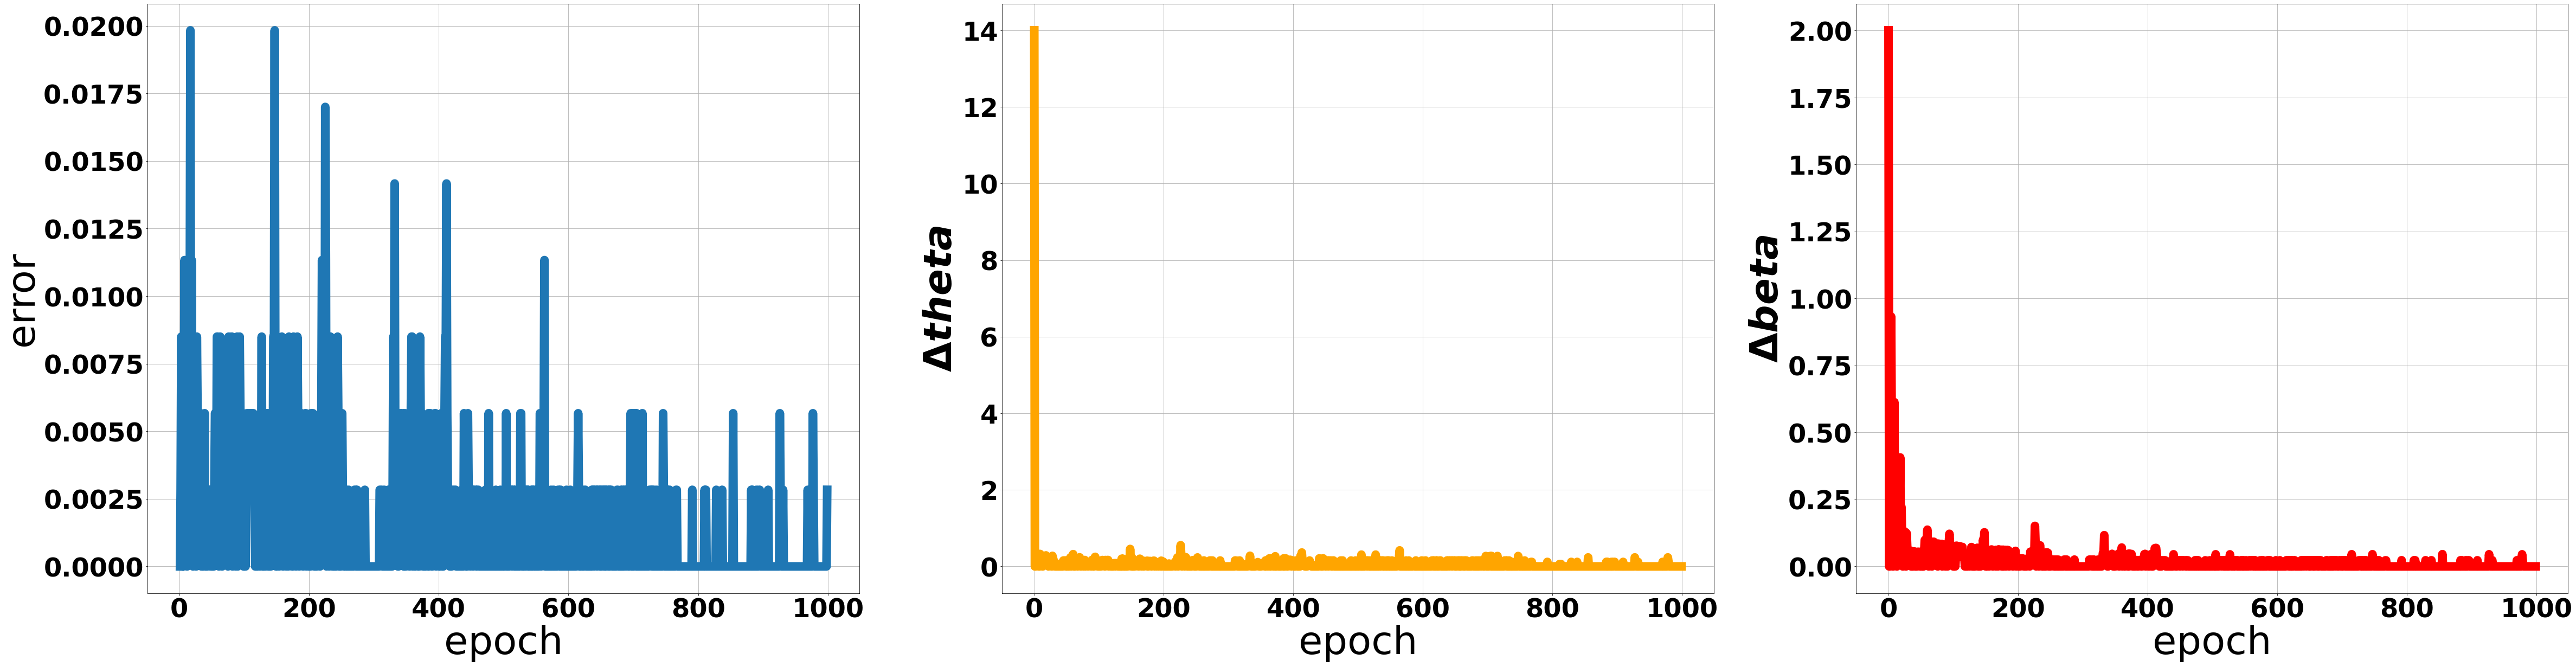

In [5]:
fig = plt.figure(figsize=(80,20))
plt.rcParams.update({'font.size': 48, 'font.weight': 'bold'})
plt.subplot(1, 3, 1)
plt.grid()
plt.xlabel('epoch', fontsize=72)
plt.ylabel(u'error', fontsize=72)
plt.plot(list(range(1, len(error_list))), error_list[1:], linewidth=16)
plt.subplot(1, 3, 2)
plt.grid()
plt.xlabel('epoch', fontsize=72)
plt.ylabel(u'$\Delta theta$', fontsize=72)
plt.plot(list(range(0, len(delta_theta_list))), delta_theta_list, c='orange', linewidth=16)
plt.subplot(1, 3, 3)
plt.grid()
plt.xlabel('epoch', fontsize=72)
plt.ylabel(u'$\Delta beta$', fontsize=72)
plt.plot(list(range(0, len(delta_beta_list))), delta_beta_list, c='red', linewidth=16)
plt.savefig('news.png')

### News Dataset

In [6]:
raw_text_list = np.load("text.npy")
num_topics = 20
max_epoches = 100

dataset = Dataset(raw_text_list, stopwords_set=stopwords_set, num_topics=num_topics)

np.set_printoptions(linewidth=120)
np.random.seed(20000121)
alpha = np.ones(num_topics) * 0.01
eta = np.ones(dataset.num_words) * 0.01
lda = LDA(num_topics=num_topics, num_words=dataset.num_words, alpha=alpha, eta=eta)
start = datetime.now()
error_list, delta_theta_list, delta_beta_list = lda.train(dataset, max_epoches=max_epoches, output_mod=4)
np.save('news_z.npy', lda.z)
print(datetime.now() - start)
topic_keywords = lda.get_topics(dataset, lda.z)
for i in range(topic_keywords.shape[0]):
    print(f'{i}: ', end='')
    for j in range(topic_keywords.shape[1]):
        print(topic_keywords[i][j], end=', ')
    print()

English Texts Number: 965
19060
epoch 0 0.0 965.0000000000001 20.00000000000001
epoch 4 0.29823771768860574 253.52209699794514 5.345842685527173
epoch 8 0.2287158536163141 181.61645268891593 4.2004349233056795
epoch 12 0.1951320846172489 152.39425590486266 3.696329754000896
epoch 16 0.1789287816362566 143.05748019249117 3.4845826821824866
epoch 20 0.16954609978187862 122.05595265107236 3.1691442802930188
epoch 24 0.15393137831942666 118.02030165733865 3.025180012030102
epoch 28 0.14621057369386836 115.75897471772227 2.9888825555940235
epoch 32 0.14375238029290585 113.98967462681517 3.0301812787848634
epoch 36 0.13488903507253402 110.07535400150755 2.8362076863741827
epoch 40 0.1313921684035592 106.40785840518355 2.6932818162164396
epoch 44 0.12512550635321815 98.77901530041304 2.5875293298120585
epoch 48 0.12207873143371534 99.69988292180028 2.587281970049255
epoch 52 0.11733545684312571 97.27476649601208 2.4524654642215022
epoch 56 0.11113803967731883 95.4586915198589 2.41733735526895

In [7]:
n_word, n_topic = lda.count(dataset, lda.z)
theta = lda.get_theta(dataset, n_topic)
print(np.argsort(-theta, axis=0)[:1])
print(np.max(theta, axis=0))

[[425 782  92 876 242 177 434 190 220 548 537 492 538 297 207  83 830 277 616 770]]
[0.97934783 0.99181034 0.99326241 0.940625   0.97934783 0.97682927 0.99246032 0.98895349 0.99274809 0.98303571
 0.91363636 0.98303571 0.98137255 0.98661972 0.96346154 0.97682927 0.97361111 0.99059406 0.99181034 0.99860499]


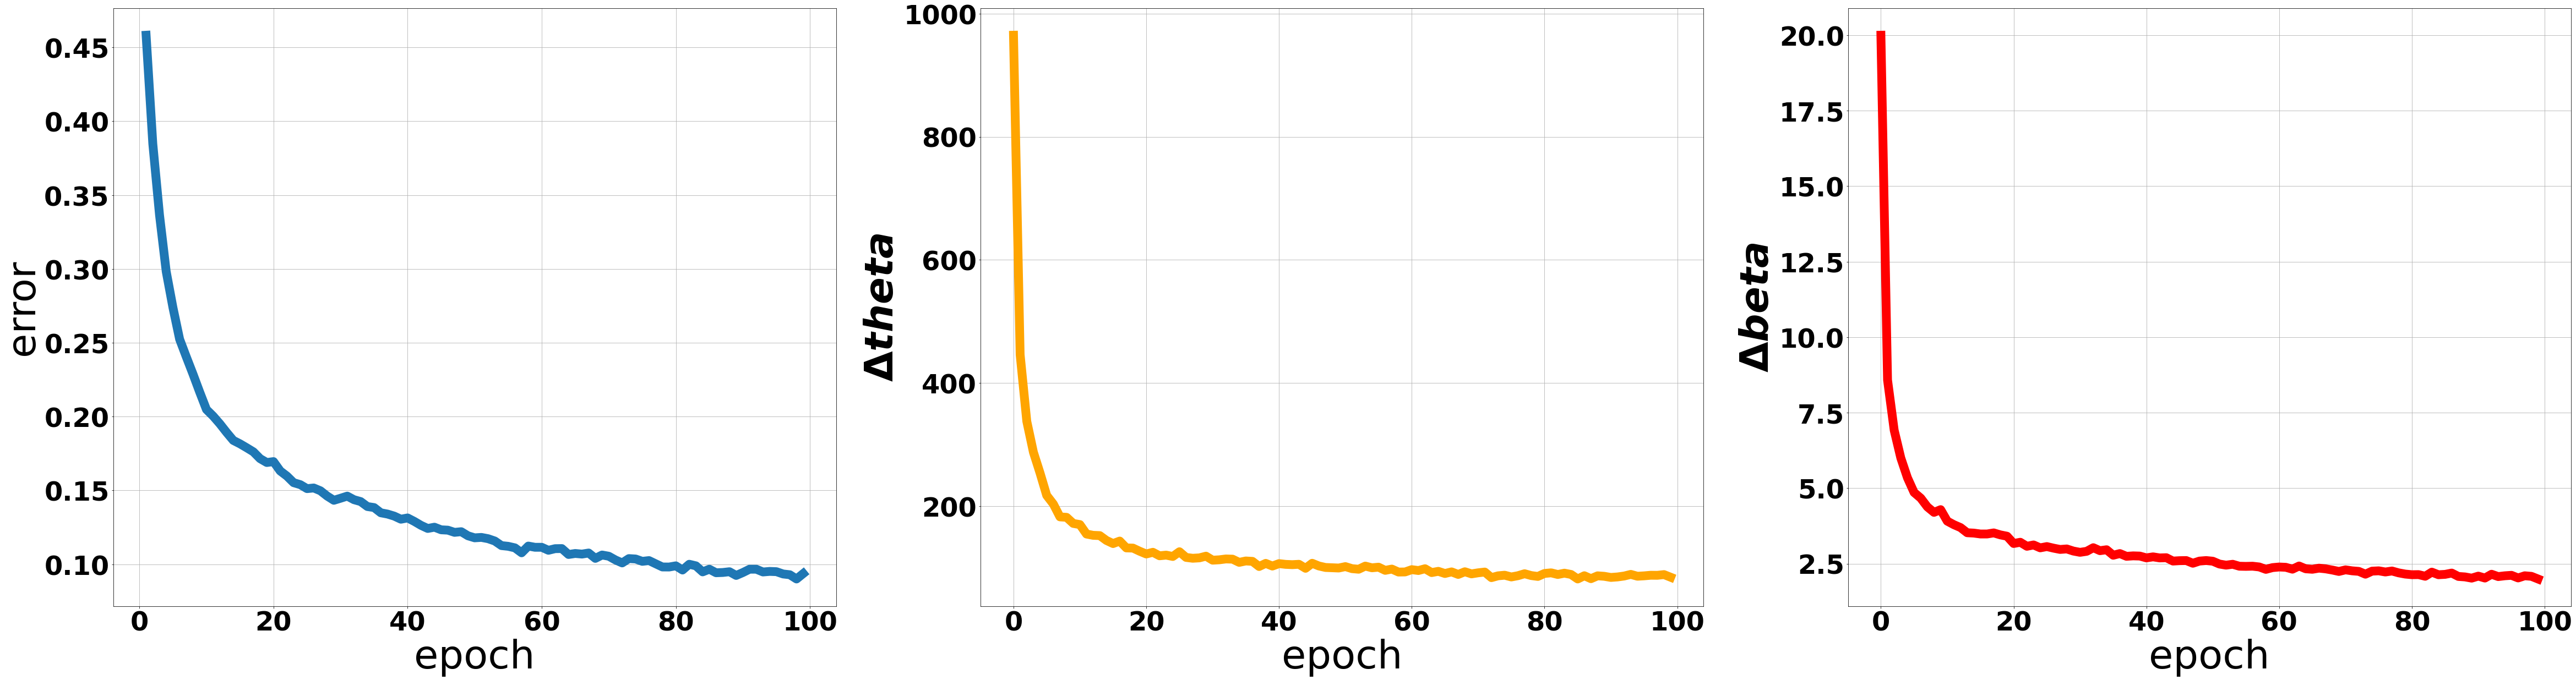

In [8]:
fig = plt.figure(figsize=(80,20))
plt.rcParams.update({'font.size': 48, 'font.weight': 'bold'})
plt.subplot(1, 3, 1)
plt.grid()
plt.xlabel('epoch', fontsize=72)
plt.ylabel(u'error', fontsize=72)
plt.plot(list(range(1, len(error_list))), error_list[1:], linewidth=16)
plt.subplot(1, 3, 2)
plt.grid()
plt.xlabel('epoch', fontsize=72)
plt.ylabel(u'$\Delta theta$', fontsize=72)
plt.plot(list(range(0, len(delta_theta_list))), delta_theta_list, c='orange', linewidth=16)
plt.subplot(1, 3, 3)
plt.grid()
plt.xlabel('epoch', fontsize=72)
plt.ylabel(u'$\Delta beta$', fontsize=72)
plt.plot(list(range(0, len(delta_beta_list))), delta_beta_list, c='red', linewidth=16)
plt.savefig('news.png')